### DFRとVFRの未来の擾乱に対する計画収束速度で比較する

仮説: DFRで運行すると未来の擾乱に対する周りの人（自分の決定に影響を及ぼしうる人）の反応が瞬時にわかるため、VFRと比べた際に擾乱に対する収束速度が高まる。その結果として交通キャパシティが上昇する。

この仮説をシミュレーション実験によって確かめる。

#### 組むべき実験系
- ノイズは1個だけ（複数にも対応できるようにはしているが速度計算周りが怪しい）


In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import copy

sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

# 初期設定（独立変数群）
CAR_NUM = 100 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 1000 # 入り口から出口までの距離 [m]
WAYPOINTS_NUM = 10 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 30 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.2
COMMUNICATION_SPEED = 0.1
TOTAL_TIME = 80
V_MAX = 40
GLOBAL_TIME_WINDOW = 100  # Strategic Phaseでの時間幅
DENSITY = 4.0 # 車がminimumで何秒に1回くるか. 
TTC = 2.5 #車間時間を暫定的に定義

def generate_arrival_times(car_num, DENSITY):
    sequence = [random.uniform(0, 5)]
    while len(sequence) < car_num:
        next_value = sequence[-1] + DENSITY + random.uniform(0, 3)
        sequence.append(next_value)
    return sequence

arrival_times = generate_arrival_times(CAR_NUM, TTC)


In [2]:
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
arrival_times = [2.65457725264784, 5.519023868368322, 8.359514841623813, 12.650984815640962, 15.816654604044085, 20.713123114743784, 25.573249947653295, 29.113823476836664, 34.064221711207054, 37.96199764959094, 41.93319466691726, 44.56571415956607, 49.07509918348945, 53.11313937451763, 57.48319736648235, 61.86162883944515, 66.9300141894827, 71.11763196557857, 73.83862502939377, 78.36291523339247, 83.00284466638122, 87.44586073702, 92.50551132803729, 95.27853797712942, 98.98841776258791, 103.9850018280912, 107.03897894776168, 109.83935708021232, 112.42192623262706, 116.77303621589067]
#arrival_times = [1, 4, 9, 15, 18, 20.6, 25, 48.18130400339028, 52.51443649098328, 57.58770193570899, 60.1]
print(arrival_times)
CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

[2.65457725264784, 5.519023868368322, 8.359514841623813, 12.650984815640962, 15.816654604044086, 20.713123114743784, 25.573249947653295, 29.113823476836664, 34.064221711207054, 37.96199764959094, 41.93319466691726, 44.56571415956607, 49.07509918348945, 53.11313937451763, 57.48319736648235, 61.86162883944515, 66.9300141894827, 71.11763196557857, 73.83862502939377, 78.36291523339247, 83.00284466638122, 87.44586073702, 92.50551132803729, 95.27853797712942, 98.98841776258791, 103.9850018280912, 107.03897894776168, 109.83935708021232, 112.42192623262706, 116.77303621589067]


In [3]:
reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})
# 各車がETAを決める部分
for idx, car in enumerate(CARS):
    desired_eta_list = car.create_desired_eta(WAYPOINTS)
    is_valid = reservation_table.validate(desired_eta_list)
    if is_valid:
        reservation_table.register(desired_eta_list)
    else:
        calibration_info = {"desired_list": desired_eta_list}
        calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
        # print(calibrated_list)
        # print()
        reservation_table.register(calibrated_list)
        car.my_list = calibrated_list

### シミュレーションの流れ

各時刻において以下の計算を行う
1. ノイズ発生フェーズ: ある時刻にもしノイズがなければ一定確率で発生させる
2. 情報更新フェーズ

   ノイズ発生フェーズで生じたノイズと、直前の時刻での情報更新に基づいて影響を受ける車を列挙.
   
   `reactive_cars`に格納
4. `reactive_cars`の先頭車がノイズに反応(処理としては`cars.react_to_noise()`).

   `cwp_table`を書き換える
6. 今の状態で一歩前進

In [4]:
simulation = DFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, \
                          reservation_table = reservation_table)
simulation.conduct_simulation(should_plot=True)

Simulation Progress:   0%|          | 0/400 [00:00<?, ?it/s]

noise created!

t=2.8000000000000003, next_car=1, current_noise= [{'x': [400, 430], 't': [20, 25]}], event_flg=arrival
carID: 0, Start:344.0, End:444.0
======update by ID:0!=======
直接ノイズの影響を受けるもの: [0]
他の車の影響: []
対象車: [0]
t=2.8000000000000003, car_id:0 avoiding noise.
avoidance by idx=0
{'x': [400, 430], 't': [20, 25]} True
17.2 3 30
eta: 17.78888888888889, 前の車に当たらない最速の時間:17.68888888888889, ノイズ開始:20
solve_acc_itinerary_early_avoid
==== START CREATING ETA====
acc_itinerary: [{'t_start': 2.8000000000000003, 'acc': 3, 'v_0': 20, 't_end': 6.133333333333334}, {'t_start': 6.133333333333334, 'acc': 0, 'v_0': 30, 't_end': 10000000.0}]
ID: 0の新しいETA（Validate前） [{'waypoint_idx': 0, 'x': 0.0, 'eta': 2.65457725264784, 'car_idx': 0, 'type': 'waypoint'}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 6.688888888888889, 'car_idx': 0, 'type': 'waypoint'}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 10.022222222222222, 'car_idx': 0, 'type': 'waypoint'}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 13.355555555555556, 'car_

ValueError: 絶対に当たってしまうノイズがあります。

In [6]:
car_1 = CARS[5]
print("ETA",car_1.my_etas)
print("===  acc_itinerary =====")
print(car_1.acc_itinerary)
print(car_1.xcor)

# print("acc:",car.acc_itinerary)
# table = simulation.reservation_table.eta_table
# print(table[table["car_idx"]<=4])

ETA [{'waypoint_idx': 0, 'x': 0.0, 'eta': 20.713123114743784, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 25.713123114743784, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 30.713123114743784, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 35.71312311474378, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 4, 'x': 400.0, 'eta': 40.71312311474378, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 5, 'x': 500.0, 'eta': 45.71312311474378, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 6, 'x': 600.0, 'eta': 50.71312311474378, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 7, 'x': 700.0, 'eta': 55.71312311474378, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 8, 'x': 800.0, 'eta': 60.71312311474378, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 9, 'x': 900.0, 'eta': 65.71312311474378, 'car_idx': 5, 'type': 'waypoint'}, {'waypoint_idx': 10, 'x': 1000.0, 'eta': 70.71312311474378, 'car

In [ ]:
a = [93.66016075511219, 90.57016032819735, 87.96530973837504, 85.84560898564528, 84.21105807000808, 82.81165699146341, 81.40479651333817, 79.99786739895927, 78.5908696483267, 77.18380326144046, 75.77666823830052, 74.3694645789069, 72.96219228325961, 71.55485135135865, 70.14744550398109, 68.739978461904, 67.33245022512736, 65.92486079365119, 64.5172101674755, 63.109498346600276, 61.70172533102553, 60.293891120751226, 58.88602118323615, 57.478140985939035, 56.0702505288599, 54.662349811998695, 53.25443883535547, 51.846517598930234, 50.43858610272292, 49.030644346733595, 47.622692330962195, 46.21472545708798, 44.80673912679009, 43.39873334006859, 41.99070809692347, 40.58266339735468, 39.17459924136227, 37.766515628946195, 36.3584125601065, 34.950313093462114, 33.542240287631955, 32.134194142616025, 30.726174658414322, 29.31818183502685, 27.91021567245366, 26.5022761706947, 25.094363329749967, 23.686492814023268, 22.278680287918462, 20.870925751435493, 19.463229204574418, 18.055590647335237, 16.648010079717892, 15.240487501722441, 13.833022913348827, 12.538062110076055, 11.468050887383015, 10.622989245269764, 10.002877183736246, 9.607714702782516, 9.43750180240852, 9.492238482614312, 9.771924743399836, 10.539085794475227, 12.056246845550618, 14.323407896626009, 17.3405689477014, 21.10772999877679, 25.62489104985218, 30.89205210092757, 36.90921315200296, 43.67637420307835, 50.818535254153744, 57.960696305229135, 65.10285735630453, 72.24501840737992, 79.38717945845531, 86.5293405095307, 93.67150156060609, 100.81366261168148, 107.95582366275687, 115.09798471383226, 122.24014576490765, 129.38230681598304, 136.52446786705843, 143.66662891813382, 150.80878996920922, 157.9509510202846, 165.09311207136, 172.2352731224354, 179.37743417351078, 186.51959522458617, 193.66175627566156, 200.80391732673695, 207.94607837781234, 215.08823942888773, 222.23040047996312, 229.3725615310385]
b= [93.66016075511219, 90.57016032819735, 87.96530973837504, 85.84560898564528, 84.21105807000808, 82.81165699146341, 81.40479651333817, 79.99786739895927, 78.5908696483267, 77.18380326144046, 75.77666823830052, 74.3694645789069, 72.96219228325961, 71.55485135135865, 70.14744550398109, 68.739978461904, 67.33245022512736, 65.92486079365119, 64.5172101674755, 63.109498346600276, 61.70172533102553, 60.293891120751226, 58.88602118323615, 57.478140985939035, 56.0702505288599, 54.662349811998695, 53.25443883535547, 51.846517598930234, 50.43858610272292, 49.030644346733595, 47.622692330962195, 46.21472545708798, 44.80673912679009, 43.39873334006859, 41.99070809692347, 40.58266339735468, 39.17459924136227, 37.766515628946195, 36.3584125601065, 34.950313093462114, 33.542240287631955, 32.134194142616025, 30.726174658414322, 29.31818183502685, 27.91021567245366, 26.5022761706947, 25.094363329749967, 23.686492814023268, 22.278680287918462, 20.870925751435493, 19.463229204574418, 18.055590647335237, 16.648010079717892, 15.240487501722441, 13.833022913348827, 12.538062110076055, 11.468050887383015, 10.622989245269764, 10.002877183736246, 9.607714702782516, 9.43750180240852, 9.492238482614312, 9.521924743399836, 9.539085794475227, 9.806246845550618, 10.323407896626009, 11.0905689477014, 12.10772999877679, 13.374891049852181, 14.892052100927572, 16.659213152002962, 18.676374203078353, 20.568535254153744, 21.960696305229135, 22.852857356304526, 23.245018407379916, 23.137179458455307, 22.779340509530698, 22.42150156060609, 22.06366261168148, 21.70582366275687, 21.34798471383226, 20.990145764907652, 20.632306815983043, 20.274467867058434, 19.916628918133824, 19.558789969209215, 19.200951020284606, 18.843112071359997, 18.485273122435387, 18.12743417351078, 17.76959522458617, 17.41175627566156, 17.05391732673695, 16.69607837781234, 16.338239428887732, 15.980400479963123, 15.6225615310385]

plt.plot(a)
plt.plot(b)

# グラフのタイトルとラベルの設定
plt.title('Line Plot of the Given List')
plt.xlabel('Index')
plt.ylabel('Value')

# グラフの表示
plt.show()


[1.0, 4.0, 9.0, 15.0, 18.0, 20.6, 25.0, 48.18130400339028, 52.51443649098328, 57.58770193570899]


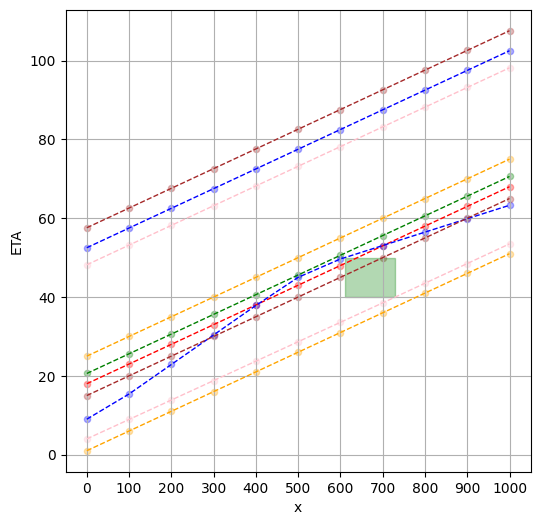

In [8]:
# print(simulation.reservation_table.eta_table[90:])
cars = simulation.CARS
print([car.itinerary[0]["eta"] for car in cars])# new_eta = [{'waypoint_idx': 0, 'x': 0.0, 'eta': 6.192323335817964, 'car_idx': 1}, {'waypoint_idx': 1, 'x': 100.0, 'eta': 6.773999748762652, 'car_idx': 1}, {'waypoint_idx': 2, 'x': 200.0, 'eta': 10.107333082095984, 'car_idx': 1}, {'waypoint_idx': 3, 'x': 300.0, 'eta': 13.440666415429318, 'car_idx': 1}, {'waypoint_idx': 4, 'x': 400.0, 'eta': 16.77399974876265, 'car_idx': 1}, {'waypoint_idx': 5, 'x': 500.0, 'eta': 20.107333082095984, 'car_idx': 1}, {'waypoint_idx': 6, 'x': 600.0, 'eta': 23.44066641542932, 'car_idx': 1}, {'waypoint_idx': 7, 'x': 700.0, 'eta': 26.773999748762648, 'car_idx': 1}, {'waypoint_idx': 8, 'x': 800.0, 'eta': 31.273999748762648, 'car_idx': 1}, {'waypoint_idx': 9, 'x': 900.0, 'eta': 36.27399974876265, 'car_idx': 1}, {'waypoint_idx': 10, 'x': 1000.0, 'eta': 41.27399974876265, 'car_idx': 1}]
simulation.reservation_table.plot_with_noise(noise_list=[noise])

In [15]:
# 動画作成
import cv2
import os
import re

# カレントディレクトリを取得
current_dir = os.getcwd()
# 画像フォルダのパス
image_folder = os.path.join(current_dir, 'images')
video_file = 'output_video_test.mp4'

# 正規表現でファイル名からtの値を抽出
def extract_t(filename):
    match = re.search(r't=(\d+\.\d+)', filename)
    if match:
        return float(match.group(1))
    return None

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = sorted(images, key=lambda x: extract_t(x))

# 画像から動画を作成
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# 動画ライターを設定
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(video_file, fourcc, 5, (width, height))  # フレームレートを5fpsに設定

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# リソースを解放
cv2.destroyAllWindows()
video.release()

# ここから下はDebug用のセル

In [12]:
import sys 
sys.path.append("../")
from utils.calc_distance_from_acc_itinerary import calc_distance_from_acc_itinerary
acc_itinerary = [{'acc': 0, 't_start': 12.650984815640962, 'v_0': 20, 't_end': 30.0}, {'t_start': 30.0, 'acc': -3, 'v_0': 20.0, 't_end': 31.0}, {'t_start': 31.0, 'acc': 0, 'v_0': 17.0, 't_end': 33.205882352941174}, {'t_start': 33.205882352941174, 'acc': 2, 'v_0': 17.0, 't_end': 39.705882352941174}, {'t_start': 39.705882352941174, 'acc': 0, 'v_0': 30.0, 't_end': 66.08088235294119}]
x = calc_distance_from_acc_itinerary(acc_itinerary, 44)
print(x)

684.5538330989456
